<div align="center">
  <img src="https://www.dropbox.com/s/vold2f3fm57qp7g/ECE4179_5179_6179_banner.png?dl=1" alt="ECE4179/5179/6179 Banner" style="max-width: 60%;"/>
</div>

<div align="center">


# MultiLayer Perceptrons (MLPs)

</div>

Welcome to **ECE4179/5179/6179 Week 6**! This week, we will study **Multi-Layer Perceptrons (MLPs)**. MLPs, the foundational architecture of neural networks, are composed of multiple layers of neurons, each layer fully connected to the next one. Despite their simplicity, MLPs are versatile and widely applied in tasks such as classification and regression. 

MLPs are **universal function approximators**, meaning that they can approximate any continuous function given enough neurons. Oh, BTW, they are the building blocks of more complex neural networks like transformers! 
</div>



With this short introduction, roll up your sleeves and let's get started!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.datasets import make_moons

# Set random seed for reproducibility
RND_SEED = 42
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)



In [3]:
# Helper function to plot the decision boundary for a 2D classification problem
from matplotlib.colors import ListedColormap
def plot_decision_boundary_moons(model, X, y, grid_size=0.01):
    # Flatten y to avoid indexing errors
    y = y.view(-1)  # Converts y from shape (1000, 1) to (1000,)
    
    # Generate a grid of points covering the feature space
    x_min, x_max = X[:, 0].min().item() - 0.5, X[:, 0].max().item() + 0.5  # Define the range for x-axis
    y_min, y_max = X[:, 1].min().item() - 0.5, X[:, 1].max().item() + 0.5  # Define the range for y-axis

    # Create a meshgrid using torch.linspace
    xx, yy = torch.meshgrid(
        torch.arange(x_min, x_max, grid_size),
        torch.arange(y_min, y_max, grid_size)
    )

    # Flatten the grid to create a list of (x, y) coordinates
    grid_points = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)  # Shape: (num_points, 2)

    # Predict the output for each point in the grid
    with torch.inference_mode():  # Disable gradient calculation for inference
        Z = model(grid_points).reshape(xx.shape)  # Get model predictions and reshape to match the grid

    # Define custom colormaps for the decision regions (red and blue shades)
    custom_cmap = ListedColormap(['#FF9999', '#9999FF'])  # Light red for class 0, light blue for class 1

    # Plot the contour and decision boundary
    plt.contourf(xx.numpy(), yy.numpy(), Z.numpy(), levels=[0, 0.5, 1], alpha=0.6, cmap=custom_cmap)  # Plot filled contour (decision regions)
    
    # Scatter plot for class 0 (label 0) in red
    plt.scatter(X[y == 0, 0].numpy(), X[y == 0, 1].numpy(), color='red', label='Class 0')
    # Scatter plot for class 1 (label 1) in blue
    plt.scatter(X[y == 1, 0].numpy(), X[y == 1, 1].numpy(), color='blue', label='Class 1')

    # Set plot limits and labels
    plt.xlim(xx.min().item(), xx.max().item())  # Set x-axis limits
    plt.ylim(yy.min().item(), yy.max().item())  # Set y-axis limits
    plt.xlabel('')  # Removes the x-label
    plt.ylabel('')  # Removes the y-label
    plt.title('Decision Boundary')  # Add a title to the plot
    plt.show()  # Display the plot


### Toy Dataset: Moons

We start by understanding how MLPs learn and realize non-linear transformations. In doing so, we'll work with a toy dataset called the **Moons dataset**. This dataset is commonly used to visualize how machine learning models handle non-linear decision boundaries. It consists of two interleaving half circles (or "moons") that are not linearly separable, making it a good testbed for our goal.

We'll generate the dataset with 1,000 samples and add a bit of noise to make it more realistic. Let's visualize the dataset to see what we are working with.


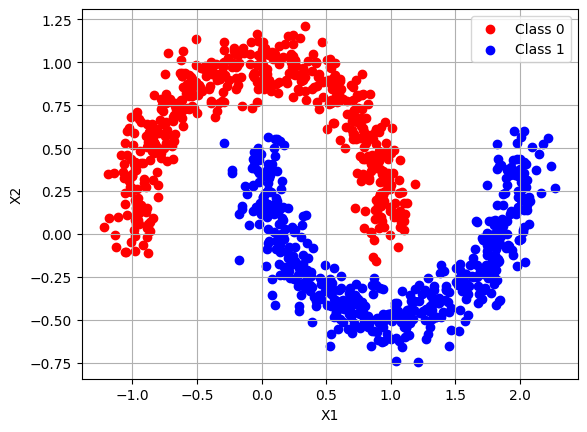

In [4]:
# Generate the moons dataset
X_moon, y_moon = make_moons(n_samples=1000, noise=0.1, random_state=RND_SEED)

# Plot the dataset
fig, ax = plt.subplots()

# Scatter plot for class 0 (label 0) in red
ax.scatter(X_moon[y_moon == 0, 0], X_moon[y_moon == 0, 1], color='red', label='Class 0')
# Scatter plot for class 1 (label 1) in blue
ax.scatter(X_moon[y_moon == 1, 0], X_moon[y_moon == 1, 1], color='blue', label='Class 1')

# Set labels and grid for better readability
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

### Defining the MLP Model

The code below defines an MLP class using PyTorch, that suits our needs in this notebook. The class allows us to create an MLP model with a customizable architecture, specifying the number of hidden layers (depth) and neurons in each layer (width). The activation function used in the hidden layers is the ReLU function. The output layer uses the sigmoid function if the size of the output is deemed to be one. This, we will need for the binary classification problem using the moons dataset. The class can also be used for multi-class classification problems but we will discuss that later in the notebook.

In [5]:
import torch.nn.init as init
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[2], output_size=1):
        super().__init__()  
        layers = nn.Sequential()  # Create an empty Sequential module to stack layers

        if hidden_sizes == []:
            # If no hidden layers, then the model is just a linear model
            layers.add_module('cls', nn.Linear(input_size, output_size))  # Name the layer 'cls'
        else:
            # Adding the first layer: input layer to the first hidden layer
            layers.add_module('fc1', nn.Linear(input_size, hidden_sizes[0]))
            layers.add_module('Relu1', nn.ReLU()) # Apply ReLU activation
            # layers.add_module(f'Leaky Relu1', nn.LeakyReLU(0.01)) # Apply ReLU activation
            
            # Adding intermediate hidden layers if any
            for i in range(1, len(hidden_sizes)):
                layers.add_module(f'fc{i+1}', nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                layers.add_module(f'Relu{i+1}', nn.ReLU()) # Apply ReLU activation
                # layers.add_module(f'Leaky Relu{i+1}', nn.LeakyReLU(0.01)) # Apply ReLU activation                                
            
            # Adding the output classification layer
            layers.add_module('cls', nn.Linear(hidden_sizes[-1], output_size))

        # add a Sigmoid activation for binary classification (if output size is 1)
        # otherwise, the model outputs logits
        if output_size == 1:
            layers.add_module('Sigmoid', nn.Sigmoid())

        # Store the complete model
        self.model = layers
        # Custom weight initialization
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight)  # He initialization for weights
                if layer.bias is not None:
                    init.zeros_(layer.bias)  # Initialize biases to zero

    # Define the forward pass (how the model processes inputs)
    def forward(self, x):
        return self.model(x) # Pass the input through the model (all layers)

### Training the MLP Model for the Moons Dataset

Now that we have defined our MLP model, let's create a function to train it on the moons dataset. The function, `train_Moon_MLP`, handles the following:

- **Binary Cross Entropy (BCE) Loss**: We use this loss function, which is well-suited for binary classification tasks.

    Recall that the BCE loss is defined as:
    
    \begin{align}
        \text{BCE}(y, \hat{y}) = -\frac{1}{m} \sum_{i=1}^{m} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)
    \end{align}

    where:
    - $m$ is the number of samples,
    - $y_i$ is the true label of the $i$-th sample, and
    - $\hat{y}_i$ is the predicted probability of the $i$-th sample.

- **Adam Optimizer**: We use the Adam optimizer, as it is often faster and more efficient than stochastic gradient descent (SGD). Feel free to experiment with other optimizers, such as SGD, to see how they compare.

- **Training Loop**: The loop runs for a specified number of epochs, performing forward passes, loss computation, backpropagation, and parameter updates.



<div style="border:2px solid red; padding: 10px; background-color: #fdd; width: 85%; color: #654321;">
    <strong>Note:</strong> We do not batch the data for the moons dataset as it is simple enough for the model to handle all data at once.
</div>





In [6]:
# Function to train the MLP on the moons dataset
def train_Moon_MLP(model, X_train, y_train, num_epochs=100, lr=0.01):
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)

    # Store the loss for each epoch
    all_losses = []

    # Training loop with progress tracking using tqdm
    with tqdm(range(num_epochs), desc="Training Epochs", unit="epoch") as pbar:
        for epoch in pbar:
            # Forward pass: compute model predictions
            y_pred = model(X_train)
        
            # Compute the binary cross entropy loss
            loss = criterion(y_pred, y_train)
            all_losses.append(loss.item())  # Append the loss for this epoch

            # Backward pass and optimization
            optimizer.zero_grad()  # Zero out gradients before BP as required by PyTorch
            loss.backward()        # Perform backpropagation
            optimizer.step()       # Update model parameters based on gradients
            
            # Update tqdm description to include loss
            if (epoch + 1) % (num_epochs // 10) == 0:
                pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete!")
    return all_losses  # Return the list of losses for further analysis


<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #1.</span>  Train a Logistic Regression Model on the Moons Dataset

As a warm-up exercise, train a logistic regression model on the moons dataset. Note that an MLP with no hidden layers is equivalent to a logistic regression model. Once you have trained the model, `plot_decision_boundary_moons` to visualize the decision boundary learned by the model. To call this function after training your logistic regression model, use:

```python
plot_decision_boundary_moons(your_trained_model, X_train, y_train)
```

</div>



In [7]:
# Convert the numpy arrays to PyTorch tensors, run this cell to convert the data
X_train = torch.tensor(X_moon, dtype=torch.float32)
y_train = torch.tensor(y_moon, dtype=torch.float32).view(-1, 1)  # Reshape y for binary classification

MLP(
  (model): Sequential(
    (cls): Linear(in_features=2, out_features=1, bias=True)
    (Sigmoid): Sigmoid()
  )
)


Epoch [200/200], Loss: 0.2558: 100%|██████████| 200/200 [00:00<00:00, 826.70epoch/s]


Training complete!


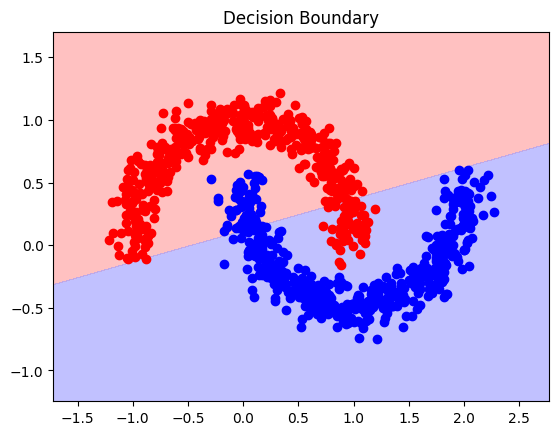

In [11]:
# A logistic regression model is equivalent to an MLP with no hidden layers, with a single output neuron,
# and sigmoid activation function with BCE loss which is what we have implemented in the MLP class
hidden_sizes = []
mlp1 = MLP(hidden_sizes=hidden_sizes)
print(mlp1)


# Train the model
loss_mlp1 = train_Moon_MLP(mlp1, X_train, y_train, num_epochs=200, lr=0.1)


plot_decision_boundary_moons(mlp1, X_train, y_train)

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #2.</span>  Train a Shallow MLP on the Moons Dataset

Now, design an MLP with one hidden layer and train it on the moons dataset. Once you have trained the model, `plot_decision_boundary_moons` to visualize the decision boundary learned by the model. Study how many neurons are needed in the hidden layer to achieve a good decision boundary.

</div>

Epoch [200/200], Loss: 0.0011: 100%|██████████| 200/200 [00:00<00:00, 1116.73epoch/s]


Training complete!


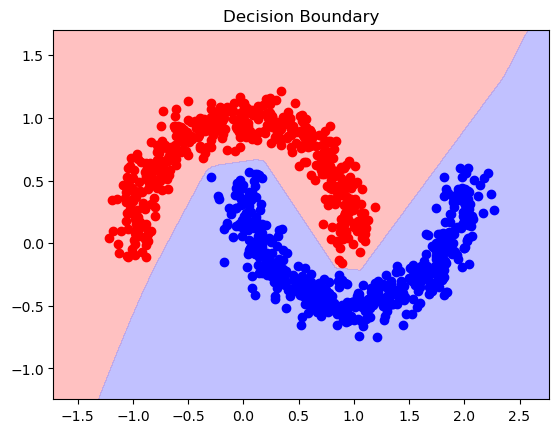

In [8]:
hidden_sizes = [32]
mlp2 = MLP(hidden_sizes=hidden_sizes)
# Train the model
loss_mlp2 = train_Moon_MLP(mlp2, X_train, y_train, num_epochs=200, lr=0.15)
# Plot the decision boundary
plot_decision_boundary_moons(mlp2, X_train, y_train)

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #3.</span>  Train a Deep MLP on the Moons Dataset

Now, that we studied a shallow MLP with one hidden layer, let us design an MLP with multiple hidden layers. Aim for a deep MLP with at least 3 hidden layers, and small width (e.g., a few neurons per layer). Train the model on the moons dataset and visualize the decision boundary learned by the model. Study how the depth of the MLP affects the decision boundary.

</div>

Epoch [200/200], Loss: 0.0017: 100%|██████████| 200/200 [00:00<00:00, 739.62epoch/s]


Training complete!


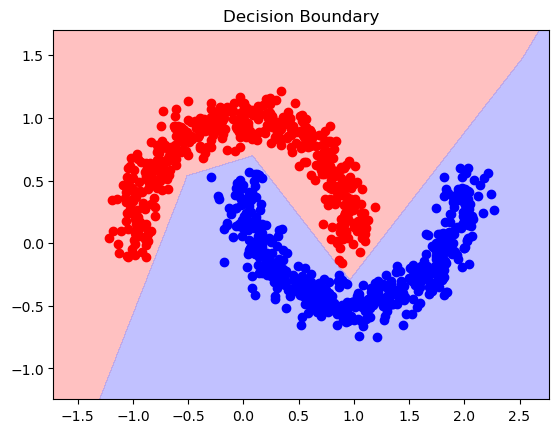

In [9]:
hidden_sizes = [4,4,4]
mlp3 = MLP(hidden_sizes=hidden_sizes)


# Train the model
loss_mlp3 = train_Moon_MLP(mlp3, X_train, y_train, num_epochs=200, lr=0.1)
# Plot the decision boundary
plot_decision_boundary_moons(mlp3, X_train, y_train)

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px; width: 95%;">

### <span style="color: pink;">Task #4.</span>  Dissecting an MLP

To gain a better understanding, we will visualize the output of every layer of an MLP for the moons dataset. This will help us understand how the model transforms the input data in each layer. To do this, you need to have a trained MLP model, where every layer has only two neurons. So, if you do not have this yet, first train a model using the following configuration: 
```python
hidden_layers = [2, 2, 2]
```
adjust learning rate and epochs, and train the model. You should aim to reach an error of less than 0.01. Once you have a trained model, use the function `visualize_mlp_layers_moon` to visualize the output of each layer for the moons dataset. Discuss with your peers the results. 

</div>

<div style="border:2px solid red; padding: 10px; background-color: #fdd; width: 95%; color: #654321;">
    <strong>Note:</strong> You may need to train the model several times, every time with a new initialization of the weights, to achieve the desired error rate. 
</div>




<details>
<summary style="color: yellow; font-weight: bold;">Hint</summary>

If you couldn't achieve the desired error rate, you can change the ReLU layers to LeakyReLU layers. To do this, either write a new MLP class or directly change the layers after instantiang your class. For example, if your model is called mlp4, you can change the ReLU at layer 1 (layers start from 0) to LeakyReLU layers as follows:

```python
# Replace the specific 'Relu1' layer with LeakyReLU
mlp4.model[1] = nn.LeakyReLU(negative_slope=0.01)
```

Note that the function `visualize_mlp_layers_moon` requires the trained model, the input data, and the true labels. You can call the function as follows:

```python
visualize_mlp_layers_moon(your_trained_model, X_train, y_train)
```

</details>

Epoch [2000/2000], Loss: 0.2451: 100%|██████████| 2000/2000 [00:06<00:00, 316.74epoch/s]


Training complete!


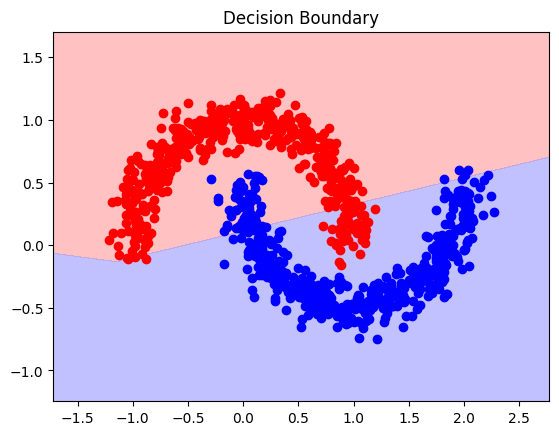

In [13]:
hidden_sizes = [2,2,2]
mlp4 = MLP(hidden_sizes=hidden_sizes)


mlp4.model[1] = nn.LeakyReLU(negative_slope=0.01)
mlp4.model[3] = nn.LeakyReLU(negative_slope=0.01)
mlp4.model[5] = nn.LeakyReLU(negative_slope=0.01)

# Train the model
loss_mlp4 = train_Moon_MLP(mlp4, X_train, y_train, num_epochs=2000, lr=0.01)
# Plot the decision boundary
plot_decision_boundary_moons(mlp4, X_train, y_train)

In [11]:
# A helper function to visualize the outputs of each layer in the MLP for the moons dataset
def visualize_mlp_layers_moon(model, X_train, y_train):
    # Function to get the outputs and names of each layer
    def get_layer_outputs_and_names(model, x):
        outputs = []
        layer_names = []
        
        for name, layer in model.model.named_children():
            x = layer(x)
            outputs.append(x.detach().numpy())
            
            # Use the actual layer name (e.g., 'fc1', 'Relu1')
            if isinstance(layer, nn.Linear):
                layer_names.append(f'{name} (Linear: {layer.in_features} → {layer.out_features})')
            elif isinstance(layer, nn.ReLU):
                layer_names.append(f'{name} (ReLU Activation)')
            elif isinstance(layer, nn.Sigmoid):
                layer_names.append(f'{name} (Sigmoid Activation)')
            else:
                layer_names.append(f'{name} ({layer.__class__.__name__})')  # Default name with layer type

        
        return outputs, layer_names

    # Get the outputs and names for the training data
    layer_outputs, layer_names = get_layer_outputs_and_names(model, X_train)
    
    # Number of layers and layout configuration
    num_layers = len(layer_outputs)
    rows = (num_layers + 1) // 2  # 2 subplots per row

    # Plotting each layer output
    fig, axes = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows
    
    for i in range(num_layers):
        ax = axes[i]
        output = layer_outputs[i]

        if output.shape[1] == 2:  # For layers with 2D output
            ax.scatter(output[:, 0], output[:, 1], c=y_train.numpy().squeeze(), cmap=plt.cm.Spectral, edgecolors='k')
            ax.set_title(f'{layer_names[i]}')
            ax.set_xlabel('Dim 1')
            ax.set_ylabel('Dim 2')
        else:  # For layers with 1D output (like the final layer)
            ax.scatter(range(len(output)), output, c=y_train.numpy().squeeze(), cmap=plt.cm.Spectral, edgecolors='k')
            ax.set_title(f'{layer_names[i]}')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel('Output Value')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()




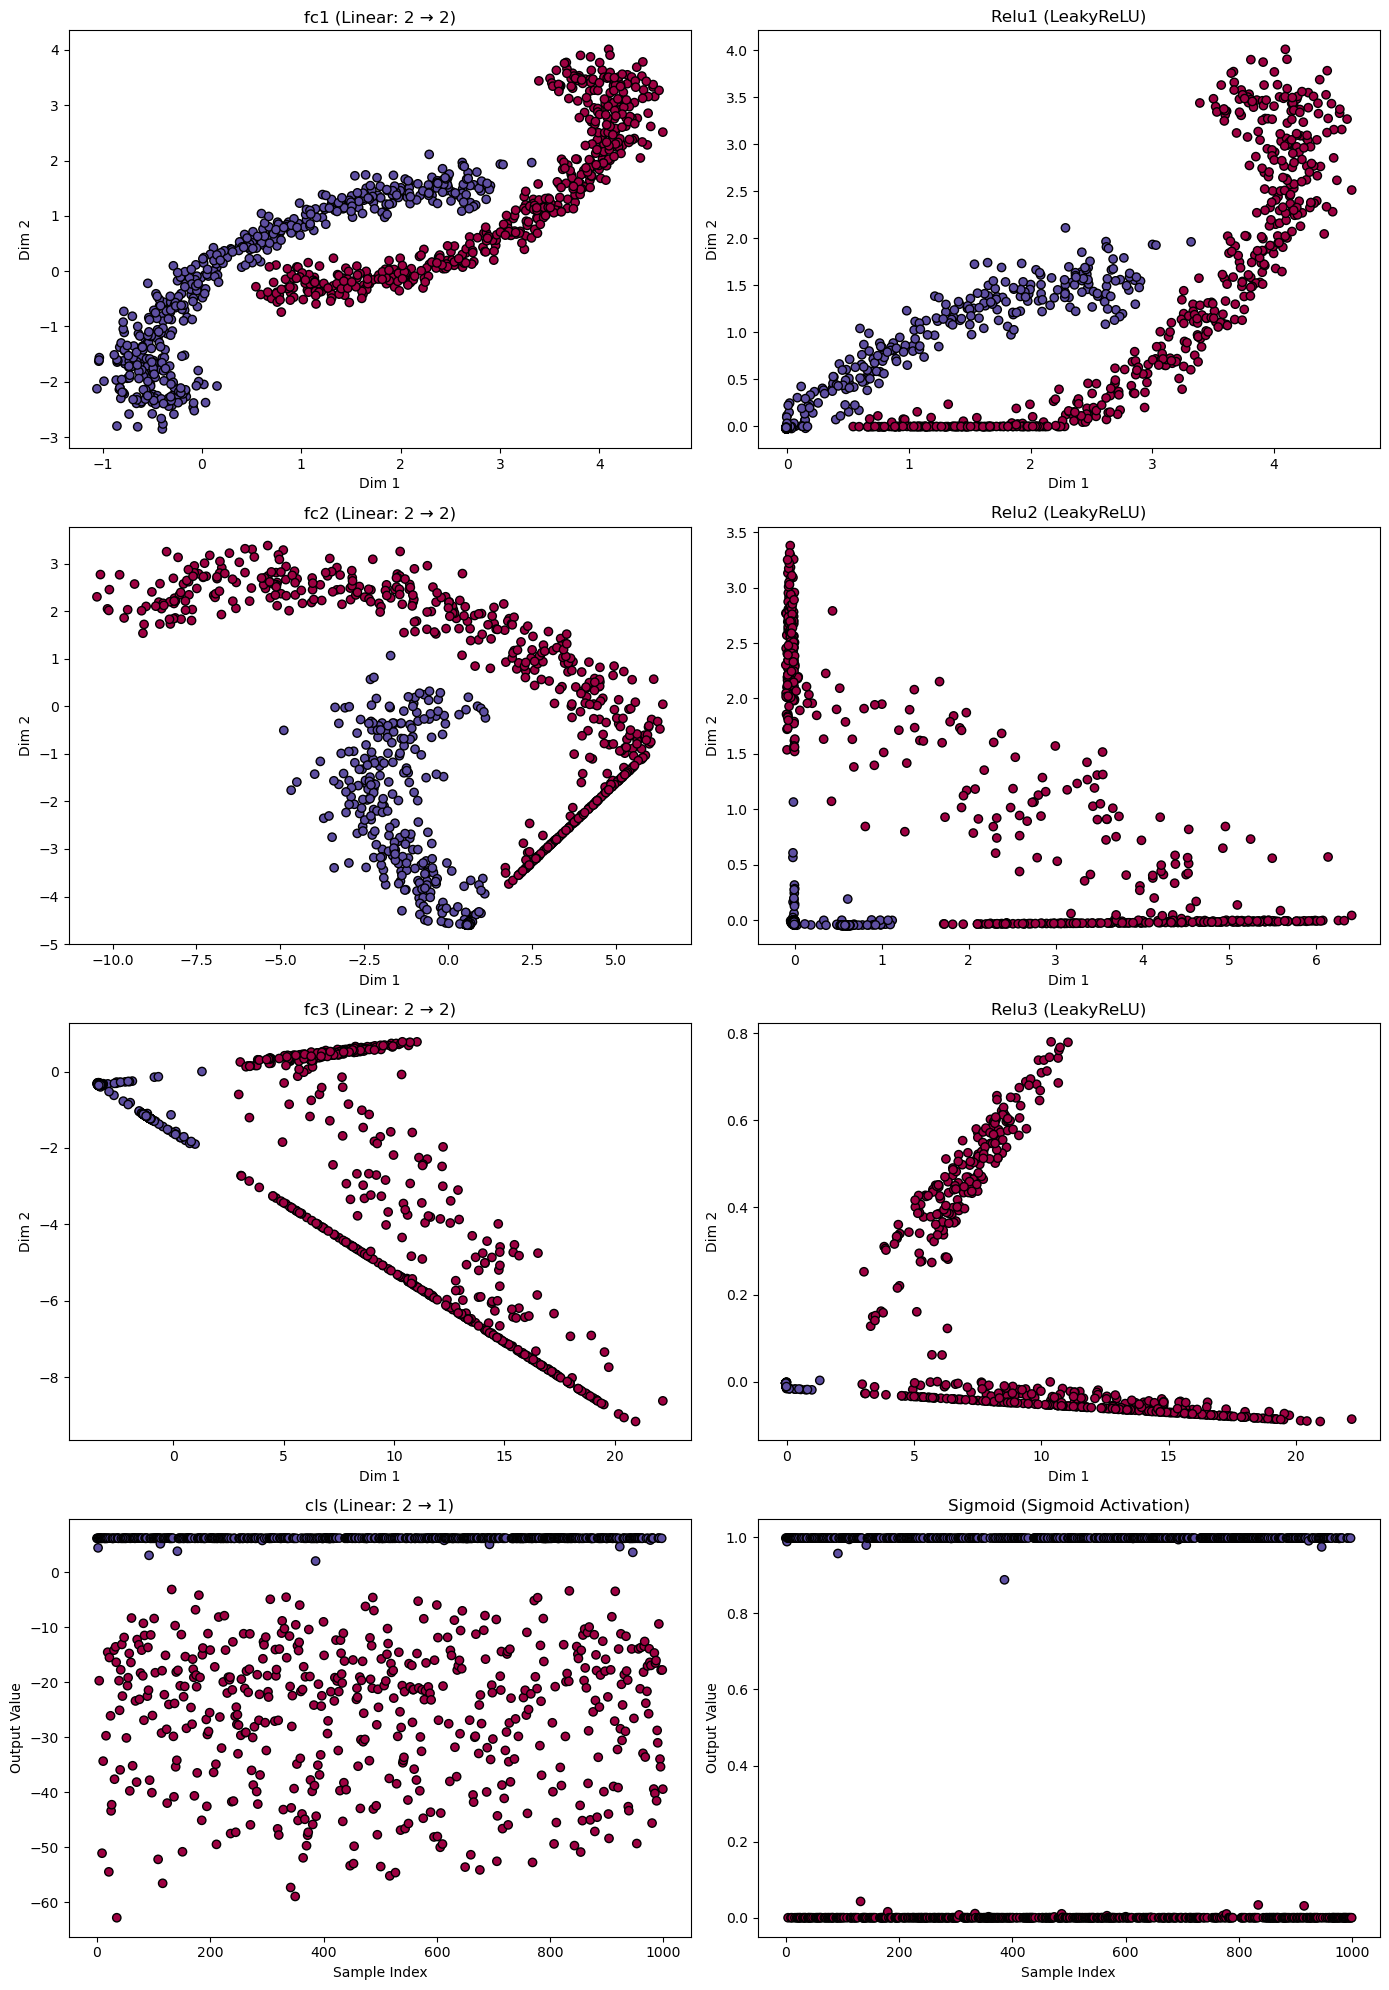

In [27]:
# Example usage:
visualize_mlp_layers_moon(mlp4, X_train, y_train)

###  Recognizing Handwritten Digits with MLPs


So far, we’ve studied the power of MLPs on the toy moons dataset. To further explore the capabilities of MLPs, we’ll now move on to the **MNIST dataset**. MNIST consists of 28x28 pixel grayscale images of handwritten digits (0-9).  To feed MNIST images to an MLP, we construct a vector of length 784 (28x28) for each image by flattening the 28x28 matrix. This vector is the input to the model. Our goal will be to better understand how MLPs work for multiclass and more sophisticated problems.



![MNIST classification](data/mnist_flatten.gif)

MNIST dataset downloaded!


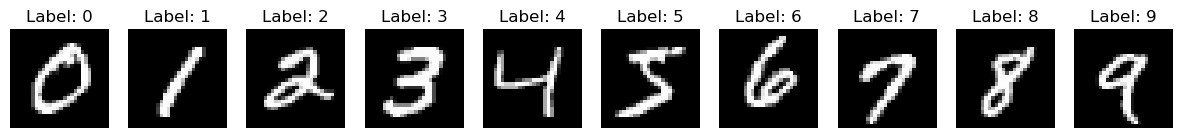

In [13]:
# Downloading the dataset

# Define the dataset path
dataset_path = '~/Documents/Datasets/'

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to have values between -1 and 1
])

# Download and load the MNIST training and test datasets
train_dataset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)



print("MNIST dataset downloaded!")

# Visualize one sample from each class (0-9)
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
# Find and plot one sample from each class
for i in range(10):
    # Find the first image of the current class (label)
    for img, label in train_dataset:
        if label == i:
            axes[i].imshow(img.squeeze(), cmap='gray')  # Squeeze to remove extra dimensions
            axes[i].set_title(f'Label: {i}')
            axes[i].axis('off')
            break  # Stop once we find a sample for the current label

plt.show()


In [14]:
# A helper function to train an MLP model on the MNIST dataset
def train_MNIST_MLP(model, train_loader, num_epochs=10, lr=0.01):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # For multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Training loop with tqdm for progress tracking
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Create tqdm progress bar for each epoch
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
            for images, labels in pbar:
                # Flatten the images from [batch_size, 1, 28, 28] to [batch_size, 784]
                images = images.view(images.size(0), -1)

                # Forward pass
                outputs = model(images)
                
                # Compute the loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # Update tqdm bar with current loss
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})

    print("Training complete!")


In [15]:
# a helper function to evaluate the model on the test dataset
def evaluate_mnist_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    with torch.inference_mode():
        for images, labels in test_loader:
            # Move data to the appropriate device            
            
            # Flatten the images from [batch_size, 1, 28, 28] to [batch_size, 784]
            images = images.view(images.size(0), -1)
            
            # Forward pass
            outputs = model(images)

            # Update accuracy metric
            accuracy.update(outputs, labels)

    # Compute the final accuracy
    final_accuracy = accuracy.compute()
    print(f'Accuracy: {final_accuracy * 100:.2f}%')


In [16]:
# a helper function to visualize the weights of a specific layer in the model
def visualize_mnist_weights(model, layer_name="cls"):
    # Check if the layer exists in the model
    if layer_name in model.model._modules:
        layer = model.model._modules[layer_name]
        
        # Ensure the layer is Linear
        if isinstance(layer, nn.Linear):
            W = layer.weight.data  # Extract the weights
            num_filters = W.shape[0]  # Number of output neurons (classes)

            # Reshape W into 28x28 images (for input size of 784)
            images = W.view(num_filters, 28, 28).cpu().numpy()

            # Number of rows to display
            rows = (num_filters + 4) // 5  # 5 columns per row
            fig, axes = plt.subplots(rows, 5, figsize=(9, 3 * rows))

            # Handle the case where there are fewer images than grid slots
            axes = axes.flatten()
            for i in range(len(axes)):
                if i < num_filters:
                    ax = axes[i]
                    # Compute min and max for each image individually
                    w_min, w_max = images[i].min(), images[i].max()
                    ax.imshow(images[i], vmin=w_min, vmax=w_max, cmap='YlGn')
                    ax.set_title(f'Neuron {i}')
                    ax.axis('off')
                else:
                    fig.delaxes(axes[i])  # Remove empty subplots

            plt.suptitle(f"Visualization of {layer_name} Weights", fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print(f"The layer '{layer_name}' is not a Linear layer.")
    else:
        print(f"The layer '{layer_name}' does not exist in the model.")


<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #5.</span>  Dissecting an MLP

We start by training an MLP without any hidden layers on the MNIST dataset. You should be able to recognize such a model. Yep, that is a simple softmax classifier. Once you have trained the model, use the function `visualize_mnist_weights` to visualize the weights of the softmax model. You can also use the function `evaluate_mnist_model` to evaluate the model on the test set. Discuss with your peers the results.

</div>

<details>
<summary style="color: yellow; font-weight: bold;">Hint</summary>
The function `visualize_mnist_weights` requires the trained model and also the name of the layer that you want to visualize (under some constraints of course). You can call the function as follows:

```python
visualize_mnist_weights(your_trained_model, "cls")
```
The `evaluate_mnist_model` function requires the trained model and the data loader of the set you want to evaluate the model on. You can call the function as follows:

```python
evaluate_mnist_model(your_trained_model, test_loader) # to evaluate on the test set
```

</details>

In [17]:
# DataLoader for batching and shuffling
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
mnist_mlp = MLP(input_size=784, hidden_sizes=[], output_size=10)
print(mnist_mlp)

MLP(
  (model): Sequential(
    (cls): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [19]:
train_MNIST_MLP(mnist_mlp, train_loader, num_epochs=10, lr=0.01)

Epoch 10/10: 100%|██████████| 235/235 [00:07<00:00, 29.85batch/s, Loss=0.3587]

Training complete!


Accuracy: 91.43%


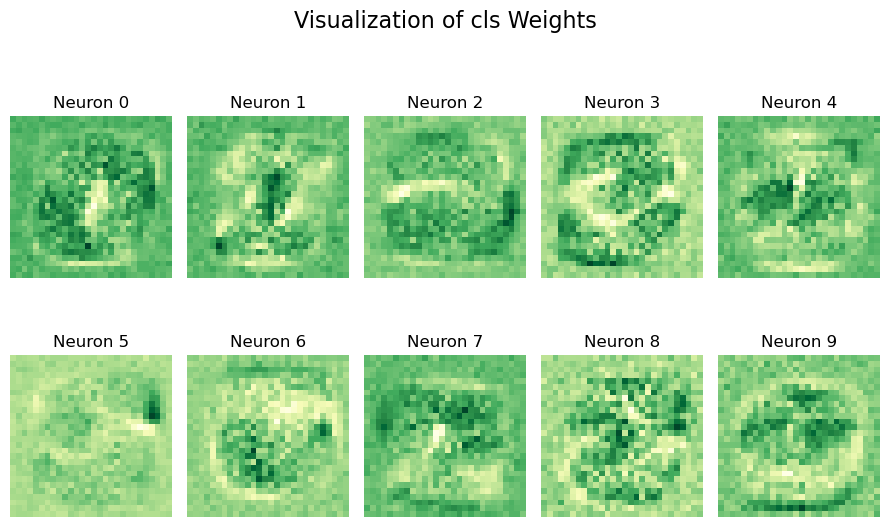

In [20]:
# evaluate the model on the test dataset
evaluate_mnist_model(mnist_mlp, test_loader)

# Visualize the weights of the model before training
visualize_mnist_weights(mnist_mlp, "cls")

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #6.</span>  Dissecting an MLP

Now train a shallow MLP with the structure $784 \to 64 \to 10$ on the MNIST dataset. Once you have trained the model, use the function `visualize_mnist_weights` to visualize the weights of the first fc layer, i.e., $784 \to 64$. Compare your model with the one you have obtained in the previous task. Discuss with your peers the results.
</div>

In [21]:
mnist_mlp2 = MLP(input_size=784, hidden_sizes=[64], output_size=10)
print(mnist_mlp2)

MLP(
  (model): Sequential(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (Relu1): ReLU()
    (cls): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [22]:
train_MNIST_MLP(mnist_mlp2, train_loader, num_epochs=20, lr=0.01)

Epoch 20/20: 100%|██████████| 235/235 [00:07<00:00, 30.45batch/s, Loss=0.1403]

Training complete!


Accuracy: 95.55%


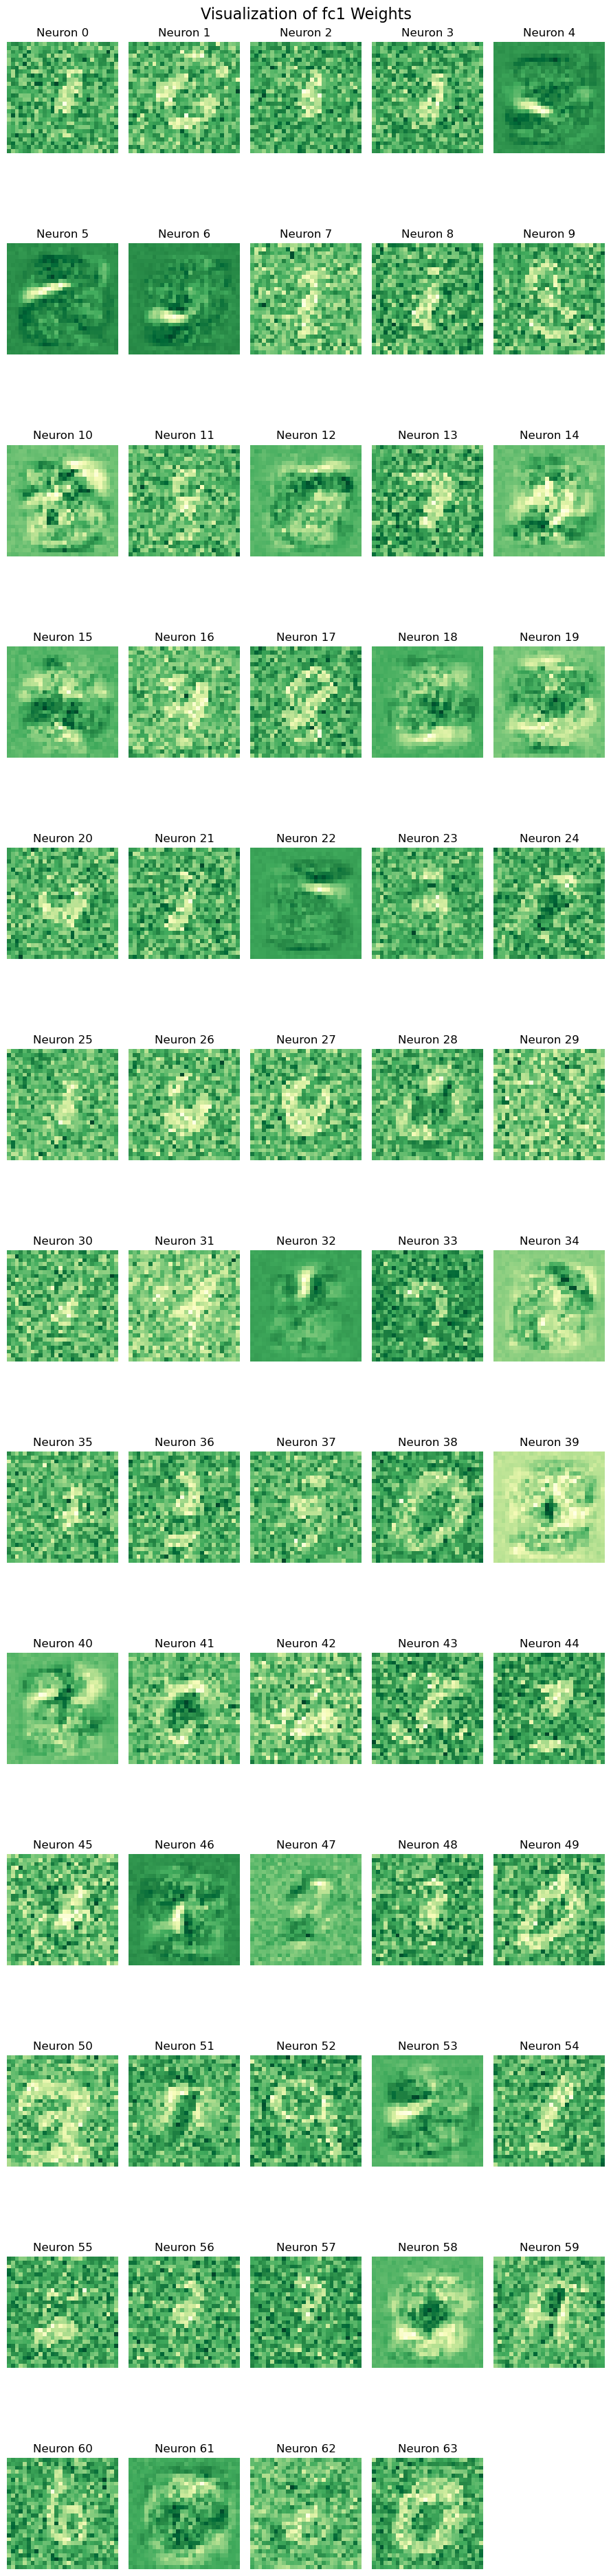

In [23]:
# evaluate the model on the test dataset
evaluate_mnist_model(mnist_mlp2, test_loader)

# Visualize the weights of the model before training
visualize_mnist_weights(mnist_mlp2, "fc1")

### Conclusion

In this notebook, we explored the power and flexibility of Multi-Layer Perceptrons (MLPs) by working with both simple toy datasets like the moons dataset and more complex, high-dimensional datasets like MNIST. We observed how MLPs can be used to learn non-linear decision boundaries and classify handwritten digits. We will see you in the next workshop.
